# Prepare

In [1]:
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

import numpy as np
import argparse
from tqdm import tqdm

from PointerNet import PointerNet

In [2]:
class TSPDataset(Dataset):
    def __init__(self, data_size, seq_len, data):
        self.data_size = data_size
        self.seq_len = seq_len
        self.data = data

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):
        matrix = self.data['Points'][index]
        label = self.data['Solution'][index]
        sample = {'Points':matrix, 'Solution':label}
        return sample

In [11]:
weights = np.load('weights_data_5city.npy')
labels = np.load('labels_data_5city.npy')
strict_weights = []
strict_labels = []

for index, value in enumerate(weights):
    if labels[index][0] == 0:
        strict_weights.append(weights[index])
        strict_labels.append(labels[index])
        
weights = np.array(strict_weights[:79000])
labels = np.array(strict_labels[:79000])

print("The max of the weights data:", weights.max())
weights = weights/weights.max()
print("The max of the weights data after scale:", weights.max())

data_num = weights.shape[0]
ratio = 70/79

weights_train = weights[:int(data_num*ratio)]
weights_test = weights[int(data_num*ratio):]
labels_train = labels[:int(data_num*ratio)]
labels_test = labels[int(data_num*ratio):]

dataset_orig = {}
dataset_orig['Points'] = torch.tensor(weights_train, dtype=torch.float32)
dataset_orig['Solution'] = torch.tensor(labels_train)

test_dataset_orig = {}
test_dataset_orig['Points'] = torch.tensor(weights_test, dtype=torch.float32)
test_dataset_orig['Solution'] = torch.tensor(labels_test)

print(dataset_orig['Points'].shape)

The max of the weights data: 32395.9297608575
The max of the weights data after scale: 1.0
torch.Size([70000, 5, 5])


In [12]:
if torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
else:
    USE_CUDA = False
    print('Cuda is not available')

Using GPU, 1 devices.


## Start Training 0-5000Epochs

In [13]:
lr = 0.0001
epochs = 5000
batch_size=2048
num_city = 5
continue_train = False

In [14]:
dataset = TSPDataset(int(data_num*ratio),
                    5,
                    dataset_orig)

test_dataset = TSPDataset(int(data_num*(1-ratio)),
                    5,
                    test_dataset_orig)

dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_dataloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True)

model = PointerNet(num_city,
                   256,
                512,
                2,
                0,
                True)

if continue_train:
    model.load_state_dict(torch.load('model_5cities_5000epochs_100000data.pth')['model'])

if USE_CUDA:
    model.cuda()
    net = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

CCE = torch.nn.CrossEntropyLoss()
model_optim = optim.Adam(filter(lambda p: p.requires_grad,
                                model.parameters()),
                        lr=lr)

losses = []
losses_test = []

for epoch in range(epochs):
    batch_loss = []
    iterator = tqdm(dataloader, unit='Batch')

    for i_batch, sample_batched in enumerate(iterator):
        iterator.set_description('Epoch %i/%i' % (epoch+1, epochs))

        train_batch = Variable(sample_batched['Points'])
        target_batch = Variable(sample_batched['Solution'])
        
        if USE_CUDA:
            train_batch = train_batch.cuda()
            target_batch = target_batch.cuda()

        o, p = model(train_batch)
        o = o.contiguous().view(-1, o.size()[-1])

        target_batch = target_batch.view(-1)

        loss = CCE(o, target_batch)

        losses.append(loss.item())
        batch_loss.append(loss.item())

        model_optim.zero_grad()
        loss.backward()
        model_optim.step()

        iterator.set_postfix(loss='{}'.format(loss.item()))
    
    for i_batch_test, sample_batched_test in test_dataloader:

        test_batch = Variable(sample_batched['Points'])
        test_target_batch = Variable(sample_batched['Solution'])
        
        if USE_CUDA:
            test_batch = test_batch.cuda()
            test_target_batch = test_target_batch.cuda()

        o_test, p_test = model(test_batch)
        o_test = o_test.contiguous().view(-1, o.size()[-1])

        test_target_batch = test_target_batch.view(-1)

        loss_test = CCE(o_test, test_target_batch)

        losses_test.append(loss_test.item())

    iterator.set_postfix(loss=np.average(batch_loss))

Epoch 1/5000:   0%|          | 0/35 [00:00<?, ?Batch/s]/rds/general/user/jd622/home/PointerNet.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(att)
Epoch 2624/5000:  11%|█▏        | 4/35 [00:00<00:02, 14.36Batch/s, loss=0.9873412847518921]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 2726/5000:  34%|███▍      | 12/35 [00:00<00:01, 14.63Batch/s, loss=0.9948625564575195]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
Notebook

# Check the loss

### Concatenate the losses

In [24]:
losses = np.load('loss_train_0_2000_scale.npy')
losses_new = np.load('loss_train_2000_4000_scale.npy')
losses_new1 = np.load('loss_train_4000_6000_scale.npy')
losses_new2 = np.load('loss_train_6000_11000_scale.npy')
losses = np.concatenate((losses, losses_new, losses_new1, losses_new2), axis = 0)
losses_test = np.load('loss_test_0_2000_scale.npy')
losses_test_new = np.load('loss_test_2000_4000_scale.npy')
losses_test_new1 = np.load('loss_test_4000_6000_scale.npy')
losses_test_new2 = np.load('loss_test_6000_11000_scale.npy')
print(len(losses_test_new2))
losses_test = np.concatenate((losses_test, losses_test_new, losses_test_new1, losses_test_new2), axis = 0)

50000


In [15]:
print(len(losses))

175000


### Calculate the loss per epoch (origin loss is per batch)

In [16]:
epoch_losses = []
epoch_losses_test = []

batch_size = 2048

for i in range(0, len(losses), int(int(data_num*ratio) / batch_size)+1):
    epoch_losses.append(np.array(losses)[i:i+int(int(data_num*ratio) / batch_size)+1].mean())
for i in range(0, len(losses_test), int(int(data_num*(1-ratio)) / batch_size)+1):
    epoch_losses_test.append(np.array(losses_test)[i:i+int(int(data_num*(1-ratio)) / batch_size)+1].mean())
    
print(len(epoch_losses))
print(len(epoch_losses_test))

5000
5000


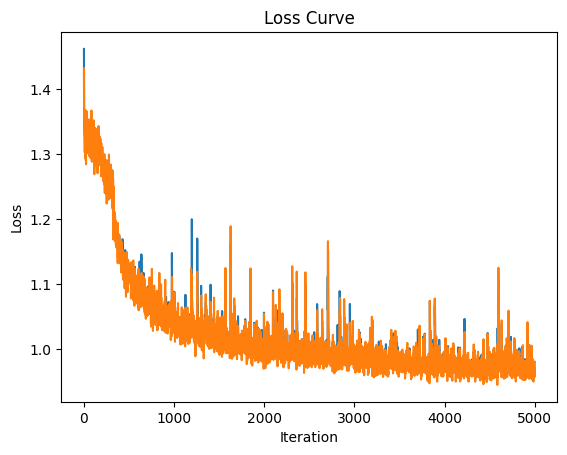

In [22]:
x = range(1, len(epoch_losses) + 1)
x_test = range(1, len(epoch_losses_test)+1)

plt.plot(x, epoch_losses)
plt.plot(x_test, epoch_losses_test)

plt.title('Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()

### Distance ratio (Pred/True)

In [12]:
model = PointerNet(num_city,
                   256,
                512,
                2,
                0,
                True)

model.load_state_dict(torch.load('model_5cities_11000epochs_100000data_scale.pth')['model'])

<All keys matched successfully>

In [19]:
total_distance_true = []
total_distance_pred = []
if USE_CUDA:
    model = model.cpu()
for index in range(int(data_num*(1-ratio))):
    o, p = model(torch.tensor(weights_test[index],dtype=torch.float32).unsqueeze(0))
    distance_pred = 0
    distance_true = 0
    for i in range(num_city):
        if i < num_city-1:
            distance_pred += weights_test[index][p[0][i]][p[0][i+1]]
            distance_true += weights_test[index][labels_test[index][i]][labels_test[index][i+1]]
        else:
            distance_pred += weights_test[index][p[0][i]][p[0][0]]
            distance_true += weights_test[index][labels_test[index][i]][labels_test[index][0]]
            
    total_distance_pred.append(distance_pred)
    total_distance_true.append(distance_true)
    
percent = []
for i, j in zip(total_distance_pred, total_distance_true):
    percent.append(i/j)
    
print("Pred total distance/True total distance (mean):", np.nanmean(percent))
print("Pred total distance/True total distance (max):", np.nanmax(percent))
print("Pred total distance/True total distance(min):", np.nanmin(percent))

Pred total distance/True total distance (mean): 1.021171940370745
Pred total distance/True total distance (max): 1.9765368813753972
Pred total distance/True total distance(min): 0.9999999999999998


/var/tmp/pbs.8191701.pbs/ipykernel_3870140/281190554.py:22: RuntimeWarning: invalid value encountered in scalar divide
  percent.append(i/j)


### Accuracy

In [20]:
ans_test = 0
ans_train = 0
if USE_CUDA:
    model = model.cpu()
for index in range(int(data_num*(1-ratio))):
    o, p = model(torch.tensor(weights_test[index],dtype=torch.float32).unsqueeze(0))
    if np.array_equal(p.squeeze(0).numpy(), labels_test[index]):
        ans_test += 1
    o, p = model(torch.tensor(weights_train[index],dtype=torch.float32).unsqueeze(0))
    if np.array_equal(p.squeeze(0).numpy(), labels_train[index]):
        ans_train += 1
print("The accurracy for test data:",round(ans_test*100/int(data_num*(1-ratio)),2),"%")
print("The accurracy for train data:",round(ans_train*100/int(data_num*(1-ratio)),2),"%")

The accurracy for test data: 67.0 %
The accurracy for train data: 87.07 %


# Save the model and loss

In [21]:
checkpoint = {
    'model': model.state_dict(),
    'optimizer': model_optim.state_dict(),
    'epoch': epoch,
    # 其他信息...
}

# 保存模型和信息到文件
torch.save(checkpoint, 'model_5cities_5000epochs_70000cleandata_scale_2048batch.pth')
np.save('loss_test_0_5000epochs_70000cleandata_scale_2048batch', losses_test)
np.save('loss_train_0_5000epochs_70000cleandata_scale_2048batch', losses)